In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [2]:
class XORDemoNet(nn.Module):
    def __init__(self):
        super(XORDemoNet, self).__init__()
        self.lin1 = nn.Linear(2, 2)
        self.lin2 = nn.Linear(2, 1)

        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        return x

In [3]:
# Get the simplest possible dataset for machine learning!
features_x_array = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target_output_y_array = np.array([[0], [1], [1], [0]])

# Convert to a torch tensor
features_x_tensor = torch.tensor(features_x_array, dtype=torch.float32)
target_output_y_tensor = torch.tensor(
    target_output_y_array, dtype=torch.float32
)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
learning_rate = 0.05

# Initialize the network
model = XORDemoNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
model(features_x_tensor)

tensor([[0.5271],
        [0.5271],
        [0.5271],
        [0.5271]], grad_fn=<SigmoidBackward0>)

In [6]:
number_of_epochs = 500

for epoch in range(number_of_epochs):
    optimizer.zero_grad()
    output = model(features_x_tensor)
    loss = criterion(output, target_output_y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

model_params = list(model.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

with torch.no_grad():
    y_predicted = model(features_x_tensor)
    print(y_predicted)

Epoch [10/500], Loss: 0.2501
Epoch [20/500], Loss: 0.2487
Epoch [30/500], Loss: 0.2419
Epoch [40/500], Loss: 0.2254
Epoch [50/500], Loss: 0.2009
Epoch [60/500], Loss: 0.1670
Epoch [70/500], Loss: 0.1222
Epoch [80/500], Loss: 0.0776
Epoch [90/500], Loss: 0.0454
Epoch [100/500], Loss: 0.0271
Epoch [110/500], Loss: 0.0176
Epoch [120/500], Loss: 0.0126
Epoch [130/500], Loss: 0.0096
Epoch [140/500], Loss: 0.0078
Epoch [150/500], Loss: 0.0065
Epoch [160/500], Loss: 0.0056
Epoch [170/500], Loss: 0.0049
Epoch [180/500], Loss: 0.0043
Epoch [190/500], Loss: 0.0038
Epoch [200/500], Loss: 0.0034
Epoch [210/500], Loss: 0.0031
Epoch [220/500], Loss: 0.0029
Epoch [230/500], Loss: 0.0026
Epoch [240/500], Loss: 0.0024
Epoch [250/500], Loss: 0.0022
Epoch [260/500], Loss: 0.0021
Epoch [270/500], Loss: 0.0019
Epoch [280/500], Loss: 0.0018
Epoch [290/500], Loss: 0.0017
Epoch [300/500], Loss: 0.0016
Epoch [310/500], Loss: 0.0015
Epoch [320/500], Loss: 0.0014
Epoch [330/500], Loss: 0.0014
Epoch [340/500], Lo

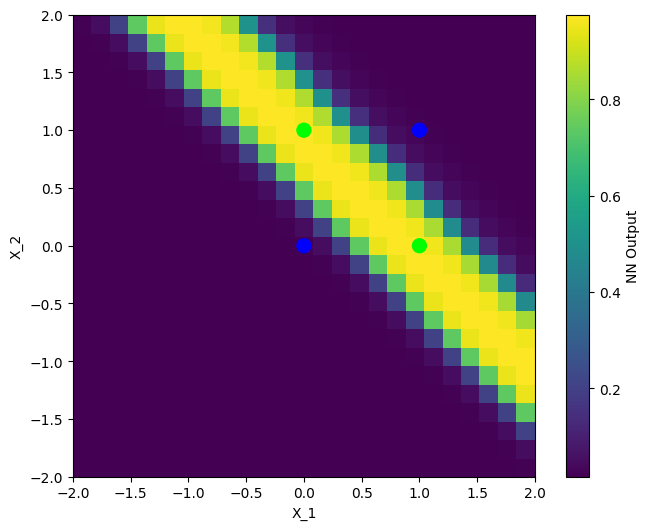

In [7]:
from data_visualizers import plot_2d_decision_surface_and_features

forward = (
    lambda x: model.forward(torch.tensor(x, dtype=torch.float32))
    .detach()
    .numpy()
)

y_predicted = model.forward(features_x_tensor)
plot_2d_decision_surface_and_features(
    x_features=features_x_array,
    y_labels=y_predicted.detach().numpy(),
    x_range=(-2, 2),
    y_range=(-2, 2),
    n_grid_points=25,
    plot_function=forward,
)